In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

In [5]:
from narrative import nar181026_heat_confidence_genes

from narrative import nar181205_networks

In [6]:
from scipy.stats import spearmanr

In [7]:
outfolder = '200609_imbalance_against_delta'

In [8]:
save_images = True

In [9]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [10]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])


In [11]:
from natsort import natsorted

In [12]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


de_set = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))

]



In [13]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'}

In [14]:
de_set['tissue'] = de_set['tissue'].replace(renamer)

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
from itertools import product

In [16]:
onditions = natsorted(de_set['condition'].unique())
ages = de_set['older'].unique()
out = pd.DataFrame(index=renamer.values(), columns=ages)


for tissue, age in product(renamer.values(), ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r

In [17]:
from natsort import natsorted

In [18]:
helper = pd.merge(de_set, pr)
f = (helper['padj'] < 0.05) & (helper['o_over_y']>0)
helper.loc[f, 'direction'] = 'up'

f = (helper['padj'] < 0.05) & (helper['o_over_y']<0)
helper.loc[f, 'direction'] = 'down'



In [19]:
helper = helper.dropna(subset=['direction'])

In [20]:
h = helper[helper['older']==24]

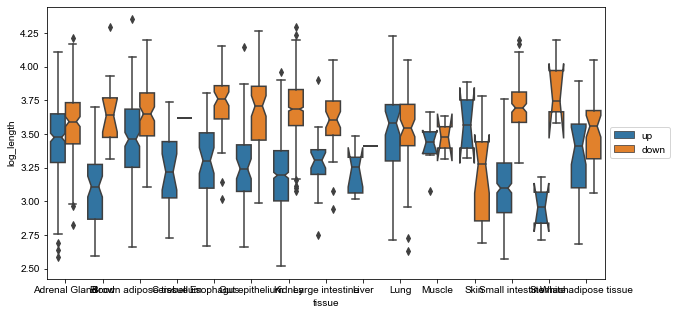

In [21]:
older = 24

h = helper[helper['older']==older].copy()
h.loc[:, 'present'] = 1

h = h[['tissue', 'direction', 'present']].drop_duplicates().pivot(
    index='tissue',
    columns='direction',
    values='present'
).fillna(0).sum(1)



plt.figure(figsize=(10, 5))
sns.boxplot(
    x='tissue',
    y='log_length',
    hue='direction',
    data=helper[helper['older']==older],
    order=natsorted(h[h==2].index),
    notch=True
)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [22]:
g = pd.merge(
    helper[helper['direction']=='up'].groupby(['tissue', 'older', 'direction'])['length'].median(
        ).to_frame('length').reset_index()[['tissue', 'older', 'length']].rename(columns={
        'length': 'length_up'}),
    helper[helper['direction']=='down'].groupby(['tissue', 'older', 'direction'])['length'].median(
        ).to_frame('length').reset_index()[['tissue', 'older', 'length']].rename(columns={
        'length': 'length_down'}))

In [23]:
g['delta'] = g['length_up'] - g['length_down']

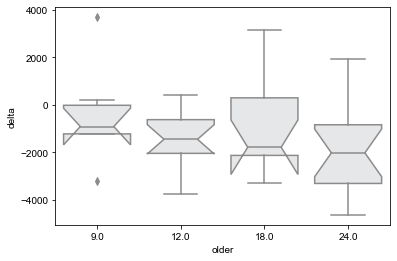

In [24]:
sns.boxplot(x='older', y='delta', data=g, notch=True, color='#E6E7E8')

if save_images:
    export.export_image('{}/changes.pdf'.format(outfolder))




In [25]:
g.groupby('older')['delta'].median()

older
9.0     -922.25
12.0   -1460.50
18.0   -1796.25
24.0   -2032.50
Name: delta, dtype: float64

In [26]:
g['older'].value_counts()

24.0    15
12.0    13
18.0    11
9.0      6
Name: older, dtype: int64

In [27]:
out

,18.0,12.0,9.0,24.0
Adrenal Gland,0.0600566,-0.0832552,-0.0036287,-0.162002
Brown adipose tissue,-0.0984448,0.0385048,-0.0153825,-0.334887
Blood,-0.188596,-0.0758902,-0.00730468,-0.646453
Frontal cortex,0.176835,0.231715,-0.0661702,0.193236
Esophagus,-0.0810182,-0.311499,-0.17002,-0.310671
Gut epithelium,-0.169653,-0.126086,-0.062721,-0.254853
Heart,0.526734,-0.155493,-0.262512,-0.199111
Kidney,0.250659,-0.281026,0.669455,-0.599801
Large intestine,-0.678338,-0.326627,-0.0305511,-0.522198
Liver,-0.113116,0.0517731,0.172214,-0.0708833


In [28]:
out_nt = g[['tissue', 'older', 'delta']].pivot(index='tissue', columns='older', values='delta')

In [29]:
together = pd.merge(
    out.rename_axis(index='tissue', columns='older').stack().to_frame('rho').reset_index(),
    out_nt.stack().to_frame('delta').reset_index())

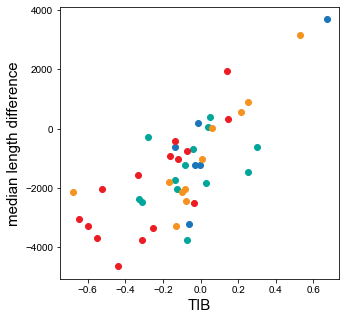

In [30]:
plt.figure(figsize=(5, 5))

for older, color in (
    (9, '#1B75BB'), (12, '#00A69C'), (18, '#F6921E'), (24, '#EC1C24')):
    
    f = together['older'] == older
    

    plt.scatter(
        together.loc[f, 'rho'], 
        together.loc[f, 'delta'],
        c=color
    )
    
plt.xlabel('TIB', fontsize=15)
plt.ylabel('median length difference', fontsize=15)


if save_images:
    export.export_image('{}/compare_to_imbalance.pdf'.format(outfolder))

In [31]:
spearmanr(
    together.loc[:, 'rho'], 
    together.loc[:, 'delta'])

SpearmanrResult(correlation=0.6806548308972659, pvalue=2.682713107748189e-07)